In [1]:
    import pandas as pd
    import numpy as np
    import joblib
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.preprocessing import LabelEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load dataset
file_path = "Career Dataset.xlsx"
df = pd.read_excel(file_path)
df

,Career,Skill
0,Software Development and Engineering,"Web Development, Mobile App Development, Artif..."
1,Development,"Web Development, Mobile App Development, Datab..."
2,Data Science,"Data Analysis and Visualization, Data Engineering"
3,Development,Web Development
4,Artificial Intelligence,"Data Analysis and Visualization, Data Analysis..."
...,...,...
3783,Data Science,"Deep Learning, Machine Learning, Data Engineer..."
3784,User Experience (UX) and User Interface (UI) D...,UI/UX Knowledge
3785,Development,"Web Development, Mobile App Development"
3786,Software Development and Engineering,Artificial Intelligence (AI) and Machine Learn...


In [3]:
# Convert 'Skill' column to lowercase for case insensitivity
df['Skill'] = df['Skill'].str.lower()

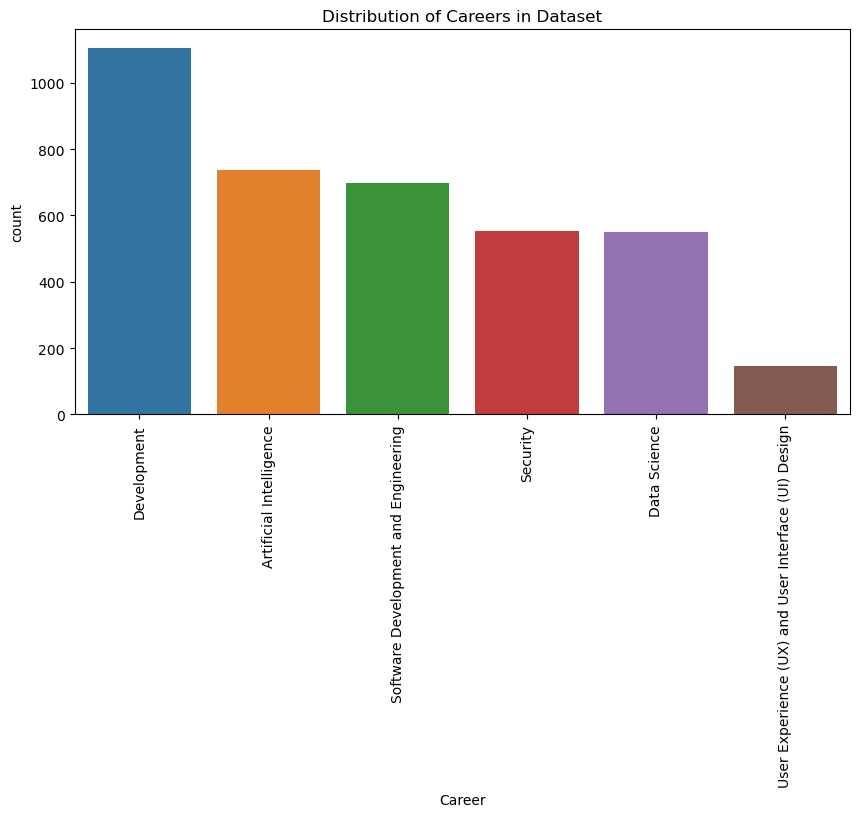

In [4]:
# Data visualization
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Career'], order=df['Career'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Careers in Dataset")
plt.show()

In [5]:
# Preprocessing
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Skill'])  # Convert skills to numerical features

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['Career'])

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Train model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 4 folds for each of 27 candidates, totalling 108 fits


In [8]:
# Model evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

Model Accuracy: 92.08%
Classification Report:
                                                      precision    recall  f1-score   support

                            Artificial Intelligence       0.90      0.94      0.92       161
                                       Data Science       0.94      0.95      0.94       108
                                        Development       0.94      0.96      0.95       206
                                           Security       0.91      0.96      0.93       102
               Software Development and Engineering       0.90      0.78      0.83       143
User Experience (UX) and User Interface (UI) Design       0.97      0.97      0.97        38

                                           accuracy                           0.92       758
                                          macro avg       0.93      0.93      0.93       758
                                       weighted avg       0.92      0.92      0.92       758



In [9]:
# Save the model and vectorizer
joblib.dump(best_model, "job_role_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(y_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [10]:
# # Prediction function with case insensitivity
# def predict_job_roles(skills):
#     skills = skills.lower()  # Convert input to lowercase
#     skills_transformed = vectorizer.transform([skills])
#     probabilities = best_model.predict_proba(skills_transformed)[0]
#     sorted_indices = np.argsort(probabilities)[::-1]  # Sort by probability in descending order
#     sorted_roles = y_encoder.inverse_transform(sorted_indices)
#     sorted_probs = probabilities[sorted_indices]
    
#     predictions = []
#     for role, prob in zip(sorted_roles, sorted_probs):
#         if prob >= 0.7:
#             predictions.append(f"High confidence: {role} ({prob:.2f})")
#         elif 0.5 <= prob < 0.7:
#             predictions.append(f"Medium confidence: {role} ({prob:.2f})")
#         elif 0.1 <= prob < 0.5:
#             predictions.append(f"Low confidence: {role} ({prob:.2f})")
#         else:
#             break  # Stop when confidence is too low
    
#     return predictions if predictions else ["Confidence too low to determine suitable job roles."]


def predict_job_roles(skills):
    skills = skills.lower()  # Convert input to lowercase
    skills_transformed = vectorizer.transform([skills])
    probabilities = best_model.predict_proba(skills_transformed)[0]
    sorted_indices = np.argsort(probabilities)[::-1]  # Sort by probability in descending order
    sorted_roles = y_encoder.inverse_transform(sorted_indices)
    sorted_probs = probabilities[sorted_indices]
    
    predictions = {
        "High confidence": [],
        "Medium confidence": [],
        "Low confidence": []
    }
    
    for role, prob in zip(sorted_roles, sorted_probs):
        if prob >= 0.7:
            predictions["High confidence"].append({"job_role": role, "Probability": round(prob, 2)})
        elif 0.5 <= prob < 0.7:
            predictions["Medium confidence"].append({"job_role": role, "Probability": round(prob, 2)})
        elif 0.1 <= prob < 0.5:
            predictions["Low confidence"].append({"job_role": role, "Probability": round(prob, 2)})
        else:
            break  # Stop when confidence is too low

    # Remove empty confidence levels
    predictions = {k: v for k, v in predictions.items() if v}

    return predictions if predictions else "Confidence too low to determine suitable job roles."



In [11]:

# # Example usage
# example_skills = "Graphic Design, Web Development"
# predicted_roles = predict_job_roles(example_skills)
# print("Predicted Job Roles:")
# for role in predicted_roles:
#     print(role)


# Example usage
example_skills = "Graphic Design, Web Development"
predicted_roles = predict_job_roles(example_skills)
print("Predicted Job Roles:", predicted_roles)

Predicted Job Roles: {'Medium confidence': [{'job_role': 'Development', 'Probability': 0.55}], 'Low confidence': [{'job_role': 'Software Development and Engineering', 'Probability': 0.17}]}


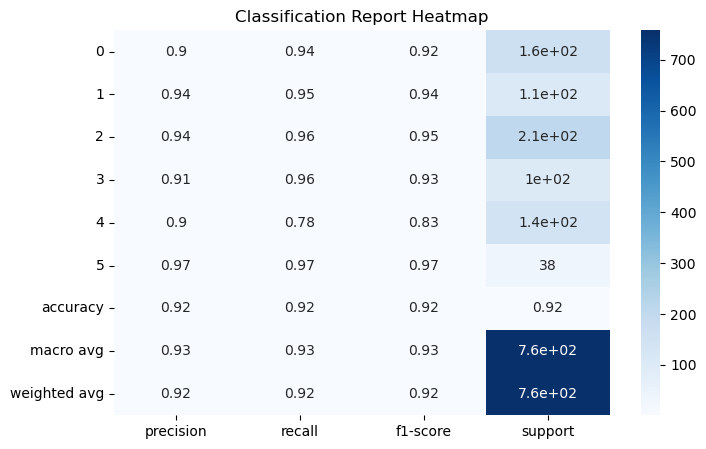

In [12]:
# Visualizing model performance
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T, annot=True, cmap="Blues")
plt.title("Classification Report Heatmap")
plt.show()
